In [2]:
# %%
# =============================================================================
# Passo 1: Importa√ß√£o de Bibliotecas
# =============================================================================

# Bibliotecas padr√£o
import csv
import gc
from pathlib import Path

# Bibliotecas de terceiros para an√°lise e manipula√ß√£o de dados
import numpy as np
import pandas as pd
import openpyxl
from scipy.stats import skew, kurtosis, ttest_ind

# Bibliotecas para visualiza√ß√£o de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Ferramentas de pr√©-processamento do Scikit-learn
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

In [3]:
# %%
# =============================================================================
# Passo 2: Carregamento e Concatena√ß√£o dos Dados
# =============================================================================

# --- Fun√ß√µes de Leitura Robusta (sem altera√ß√£o) ---
def detectar_delimitador(caminho_arquivo: Path, tamanho_amostra: int = 65536) -> str:
    with caminho_arquivo.open("rb") as f:
        amostra = f.read(tamanho_amostra)
    for enc in ("utf-8", "latin-1", "cp1252"):
        try:
            texto = amostra.decode(enc, errors="strict")
            dialect = csv.Sniffer().sniff(texto, delimiters=";,")
            return dialect.delimiter
        except Exception:
            continue
    return ";"

def ler_csv_robusto(caminho_arquivo: Path) -> pd.DataFrame:
    sep_detectado = detectar_delimitador(caminho_arquivo)
    encodings = ("utf-8-sig", "utf-8", "latin-1", "cp1252")
    erros = []
    for enc in encodings:
        try:
            # Usar low_memory=False para evitar infer√™ncia de tipo por chuncks, prevenindo erros
            return pd.read_csv(caminho_arquivo, sep=sep_detectado, encoding=enc, low_memory=False, engine="c")
        except Exception as e:
            erros.append((f"engine=c | {enc}", str(e)))
    
    # Fallback para engine python se o 'c' falhar
    for enc in encodings:
        try:
            return pd.read_csv(caminho_arquivo, sep=sep_detectado, encoding=enc, engine="python", on_bad_lines="skip")
        except Exception as e:
            erros.append((f"engine=python | {enc}", str(e)))
            
    msg = f"Falha ao ler {caminho_arquivo.name}. Erros:\\n" + "\\n".join([f" - {ctx}: {err}" for ctx, err in erros])
    raise RuntimeError(msg)



In [4]:
# --- Processo de Leitura e Concatena√ß√£o ---

# Caminho para a pasta com os arquivos CSV
pasta_csvs = Path.cwd() / "Bases" / "0_RAIS_Bases_Amostra" / "RAIS_Enap_amostra_"
assert pasta_csvs.exists(), f"Pasta n√£o encontrada: {pasta_csvs}"

# Listar e ler os arquivos
arquivos_csv = sorted([p for p in pasta_csvs.glob("*.csv")])
if not arquivos_csv:
    raise FileNotFoundError("Nenhum CSV encontrado na pasta indicada.")

print(f"Arquivos encontrados: {len(arquivos_csv)}")
dataframes = []
for idx, arq in enumerate(arquivos_csv, start=1):
    print(f"[{idx}/{len(arquivos_csv)}] Lendo: {arq.name} ...", end="")
    df_tmp = ler_csv_robusto(arq)
    dataframes.append(df_tmp)
    print(f" ok ({df_tmp.shape[0]} linhas, {df_tmp.shape[1]} colunas)")

# Concatena todos os DataFrames em um s√≥
print("\\nConcatenando DataFrames...")
df = pd.concat(dataframes, ignore_index=True)
print("Dimens√£o final:", df.shape)



Arquivos encontrados: 11
[1/11] Lendo: RAIS_2014_Enap_amostra.csv ... ok (1128887 linhas, 37 colunas)
[2/11] Lendo: RAIS_2015_Enap_amostra.csv ... ok (1090572 linhas, 37 colunas)
[3/11] Lendo: RAIS_2016_Enap_amostra.csv ... ok (726162 linhas, 37 colunas)
[4/11] Lendo: RAIS_2017_Enap_amostra.csv ... ok (1073850 linhas, 37 colunas)
[5/11] Lendo: RAIS_2018_Enap_amostra.csv ... ok (1082710 linhas, 37 colunas)
[6/11] Lendo: RAIS_2019_Enap_amostra.csv ... ok (796532 linhas, 37 colunas)
[7/11] Lendo: RAIS_2020_Enap_amostra.csv ... ok (1109627 linhas, 37 colunas)
[8/11] Lendo: RAIS_2021_Enap_amostra.csv ... ok (1199769 linhas, 37 colunas)
[9/11] Lendo: RAIS_2022_Enap_amostra.csv ... ok (1245516 linhas, 37 colunas)
[10/11] Lendo: RAIS_2023_Enap_amostra.csv ... ok (1328596 linhas, 37 colunas)
[11/11] Lendo: RAIS_2024_Enap_amostra.csv ... ok (985182 linhas, 37 colunas)
\nConcatenando DataFrames...
Dimens√£o final: (11767403, 37)


In [5]:
# --- Otimiza√ß√£o de Mem√≥ria ---
# Remove a lista de dataframes e o dataframe tempor√°rio da mem√≥ria
del dataframes
del df_tmp
gc.collect() # Executa o garbage collector para liberar mem√≥ria
print("Mem√≥ria liberada.")


Mem√≥ria liberada.


In [6]:
# %%
# =============================================================================
# Passo 3: Limpeza, Filtragem e Transforma√ß√£o dos Dados (Vers√£o Corrigida)
# =============================================================================

# --- 3.1: Remo√ß√£o de Colunas Desnecess√°rias ---
colunas_para_remover = [
    "VinculoAtivo", "NRMesDesligamento", "TPAdmissao", "TPEstabelecimento", 
    "TPDeficiencia", "CDCausaAfastamento1", "CDCausaAfastamento2", "CDCausaAfastamento3", 
    "INTrabIntermitente", "VLRemunDezembroNom", "VLRemunDezembroSM", "VLSalarioContratual",
    "NRCNPJCEI", "NRCNPJRaiz", "CDCNAE20Subclasse"
]
existentes = [c for c in colunas_para_remover if c in df.columns]
df.drop(columns=existentes, inplace=True)
gc.collect()
print(f"Colunas removidas: {len(existentes)}. Shape ap√≥s remo√ß√£o: {df.shape}")


Colunas removidas: 15. Shape ap√≥s remo√ß√£o: (11767403, 22)


In [7]:
# --- 3.2: Convers√£o de Tipos de Dados ---
print("Convertendo tipos de dados...")
colunas_categoricas = [
    "CDDesligamento", "CDGrauEscolaridade", "CDNaturezaJuridica", "CDRacaCor", 
    "CDSexo", "CDTamanhoEstabelecimento", "INPortadorDefic", "INTrabParcial", 
    "TPVinculo", "CDCNAE20Classe", "CDMunicipio"
]
for col in colunas_categoricas:
    if col in df.columns:
        df[col] = df[col].astype("category")

if "DTAdmissaoDeclarada" in df.columns:
    df["DTAdmissaoDeclarada"] = pd.to_datetime(df["DTAdmissaoDeclarada"], errors='coerce', dayfirst=True)

# CORRE√á√ÉO: For√ßa a coluna CBO para string ANTES de qualquer outra opera√ß√£o
# Isso evita o erro de convers√£o para int no momento de salvar o Parquet.
if 'CDCBOOcupacao2002' in df.columns:
    df['CDCBOOcupacao2002'] = df['CDCBOOcupacao2002'].astype(str)

Convertendo tipos de dados...


In [8]:
# --- 3.3: Limpeza de Sal√°rios (Outliers) ---
print("Limpando outliers de remunera√ß√£o...")
df.dropna(subset=["VLRemunMediaNom"], inplace=True)
df = df[(df["VLRemunMediaSM"] >= 0.3) & (df["VLRemunMediaSM"] <= 150)]
print(f"Shape ap√≥s limpeza de sal√°rios: {df.shape}")


Limpando outliers de remunera√ß√£o...
Shape ap√≥s limpeza de sal√°rios: (11357549, 22)


In [9]:
# --- 3.4: Cria√ß√£o de Novas Colunas (Features) ---
print("Criando novas colunas...")
df['log_VLRemunMediaNom'] = np.log1p(df['VLRemunMediaNom'])

ocupacoes_map = {
    '0': 'FOR√áAS ARMADAS, POLICIAIS E BOMBEIROS', '1': 'DIRIGENTES E GERENTES',
    '2': 'CI√äNCIAS E ARTES', '3': 'T√âCNICOS DE N√çVEL M√âDIO', '4': 'SERVI√áOS ADMINISTRATIVOS',
    '5': 'SERVI√áOS E VENDEDORES', '6': 'AGROPECU√ÅRIOS E PESCA', '7': 'PRODU√á√ÉO INDUSTRIAL (1)',
    '8': 'PRODU√á√ÉO INDUSTRIAL (2)', '9': 'REPARA√á√ÉO E MANUTEN√á√ÉO'
}
df['GrupoOcupacao'] = df['CDCBOOcupacao2002'].str[0].map(ocupacoes_map).astype("category")


Criando novas colunas...


In [10]:
# --- 3.5: Filtragem por Capitais ---
print("Filtrando registros apenas das capitais...")
codigos_capitais = [
    431490, 330455, 520870, 355030, 250750, 261160, 221100, 292740, 510340, 150140, 
    410690, 270430, 230440, 240810, 280030, 110020, 120040, 130260, 500270, 310620, 
    421660, 172100, 160060, 211130, 320530, 530010
]
df['CDMunicipio'] = df['CDMunicipio'].astype('int64')
df = df[df['CDMunicipio'].isin(codigos_capitais)].copy()
gc.collect()
print(f"Pr√©-processamento conclu√≠do. Shape final do DataFrame de an√°lise: {df.shape}")


Filtrando registros apenas das capitais...
Pr√©-processamento conclu√≠do. Shape final do DataFrame de an√°lise: (4257681, 24)


In [11]:
# %%
# =============================================================================
# Passo 4: Salvamento do DataFrame Processado
# =============================================================================
saida_parquet = pasta_csvs / "RAIS_CAPITAIS_PROCESSADO.parquet"
df.to_parquet(saida_parquet, index=False, engine="pyarrow", compression="snappy")

print(f"DataFrame final salvo com sucesso em: {saida_parquet}")

DataFrame final salvo com sucesso em: C:\Users\Guilherme\OneDrive\Cursos\ENAP\MBA em Intelig√™ncia Artificial\Disciplinas\18 - Lab 02\Bases\0_RAIS_Bases_Amostra\RAIS_Enap_amostra_\RAIS_CAPITAIS_PROCESSADO.parquet


In [12]:
# %%
# =============================================================================
# Passo 5: An√°lise Explorat√≥ria e Testes de Hip√≥teses
# =============================================================================

# Configura√ß√µes de exibi√ß√£o do Pandas
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

# Verifica√ß√£o inicial dos dados
print("Tipos de dados do DataFrame final:")
display(df.info())

print("\\nVisualiza√ß√£o das primeiras linhas:")
display(df.head())

Tipos de dados do DataFrame final:
<class 'pandas.core.frame.DataFrame'>
Index: 4257681 entries, 1 to 11767401
Data columns (total 24 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   NRANO                     int64         
 1   CDMunicipio               int64         
 2   TPVinculo                 category      
 3   CDDesligamento            category      
 4   TPSalario                 float64       
 5   CDGrauEscolaridade        category      
 6   CDSexo                    category      
 7   CDRacaCor                 category      
 8   INPortadorDefic           category      
 9   CDTamanhoEstabelecimento  category      
 10  CDNaturezaJuridica        category      
 11  DTAdmissaoDeclarada       datetime64[ns]
 12  VLRemunMediaNom           float64       
 13  VLRemunMediaSM            float64       
 14  NRTempoEmprego            float64       
 15  NRQtdHoraContr            float64       
 16  CDCBOOcupacao2002      

None

\nVisualiza√ß√£o das primeiras linhas:


NRANO  CDMunicipio TPVinculo CDDesligamento  TPSalario CDGrauEscolaridade CDSexo CDRacaCor INPortadorDefic CDTamanhoEstabelecimento CDNaturezaJuridica  \
1    2014       530010        30            0.0        1.0                9.0    2.0      99.0             0.0                     10.0             1040.0   
8    2014       130260        10            0.0        1.0                7.0    1.0       8.0             0.0                      8.0             2062.0   
9    2014       211130        10            0.0        1.0                7.0    1.0       8.0             1.0                      8.0             2062.0   
18   2014       355030        10            0.0        1.0                9.0    2.0       2.0             0.0                      9.0             1112.0   
23   2014       250750        10            0.0        1.0                9.0    1.0       2.0             0.0                      7.0             2062.0   

   DTAdmissaoDeclarada  VLRemunMediaNom  VLRemunMediaSM  NRTempoEmprego  NRQtdHoraContr CDCBOOcupacao2002 CDCNAE20Classe  NRIdade INTrabParcial  \
1           2005-04-03         23283.31           32.15           117.8            40.0            111405        84116.0     38.0           0.0   
8                  NaT           749.30            1.03            22.3            44.0            412205        53202.0     27.0           0.0   
9                  NaT          1082.88            1.49            15.3            44.0            784205        10929.0     37.0           0.0   
18                 NaT         11864.12           16.38           378.1            40.0            239410        85325.0     49.0           0.0   
23          1991-01-03         10047.07           13.87           285.9            44.0            142305        60217.0     72.0           0.0   

    Estoque_Total  Estoque_Fem  log_VLRemunMediaNom             GrupoOcupacao  
1          6135.0       2523.0            10.055535     DIRIGENTES E GERENTES  
8           345.0        252.0             6.620473  SERVI√áOS ADMINISTRATIVOS  
9           433.0        181.0             6.988302   PRODU√á√ÉO INDUSTRIAL (1)  
18          516.0        273.0             9.381358          CI√äNCIAS E ARTES  
23          216.0         75.0             9.215136     DIRIGENTES E GERENTES

Resumo estat√≠stico:
count    4257681.00
mean        4430.63
std         6556.31
min          217.20
1%           581.16
5%           914.00
25%         1460.60
50%         2222.44
75%         4463.25
95%        15583.52
99%        32883.11
max       209000.00
Name: VLRemunMediaNom, dtype: float64

Assimetria (skew): 5.939  |  Curtose (kurtosis): 69.292
Zeros absolutos: 0


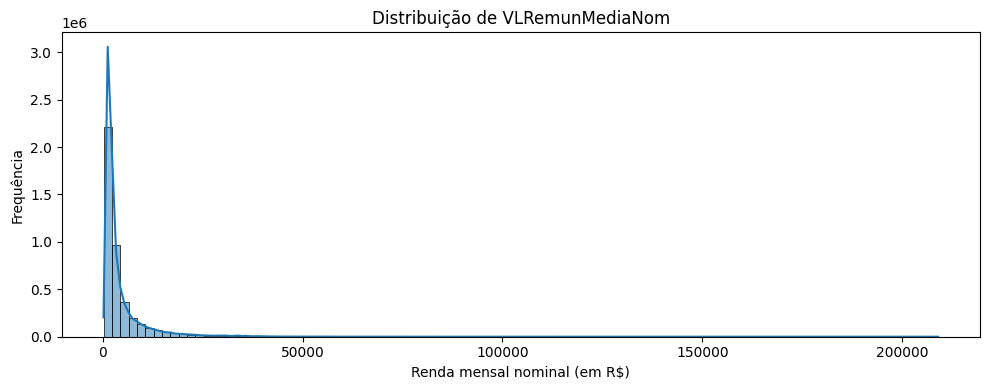

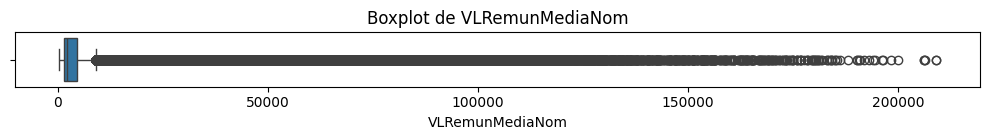

In [13]:
# %% An√°lise univariada da vari√°vel VLRemunMediaNom (j√° filtrada)

col = "VLRemunMediaNom"
s = pd.to_numeric(df[col], errors="coerce").dropna()

print("Resumo estat√≠stico:")
print(s.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).round(2))
print(f"\nAssimetria (skew): {s.skew():.3f}  |  Curtose (kurtosis): {s.kurt():.3f}")
print(f"Zeros absolutos: {(s==0).sum()}")

# Histograma
plt.figure(figsize=(10,4))
sns.histplot(s, bins=100, kde=True)
plt.title("Distribui√ß√£o de VLRemunMediaNom")
plt.xlabel("Renda mensal nominal (em R$)")
plt.ylabel("Frequ√™ncia")
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(10,1.5))
sns.boxplot(x=s)
plt.title("Boxplot de VLRemunMediaNom")
plt.tight_layout()
plt.show()


In [14]:
# %% An√°lise univariada da vari√°vel VLRemunMediaNom (j√° filtrada)
# Verificando a distribui√ß√£o da remunera√ß√£o ap√≥s a limpeza de outliers.

col = "VLRemunMediaNom"
s = pd.to_numeric(df[col], errors="coerce").dropna()

print("Resumo estat√≠stico da Remunera√ß√£o (P√≥s-filtro):")
print(s.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).round(2))
print(f"\\nAssimetria (skew): {s.skew():.3f}  |  Curtose (kurtosis): {s.kurt():.3f}")


Resumo estat√≠stico da Remunera√ß√£o (P√≥s-filtro):
count    4257681.00
mean        4430.63
std         6556.31
min          217.20
1%           581.16
5%           914.00
25%         1460.60
50%         2222.44
75%         4463.25
95%        15583.52
99%        32883.11
max       209000.00
Name: VLRemunMediaNom, dtype: float64
\nAssimetria (skew): 5.939  |  Curtose (kurtosis): 69.292


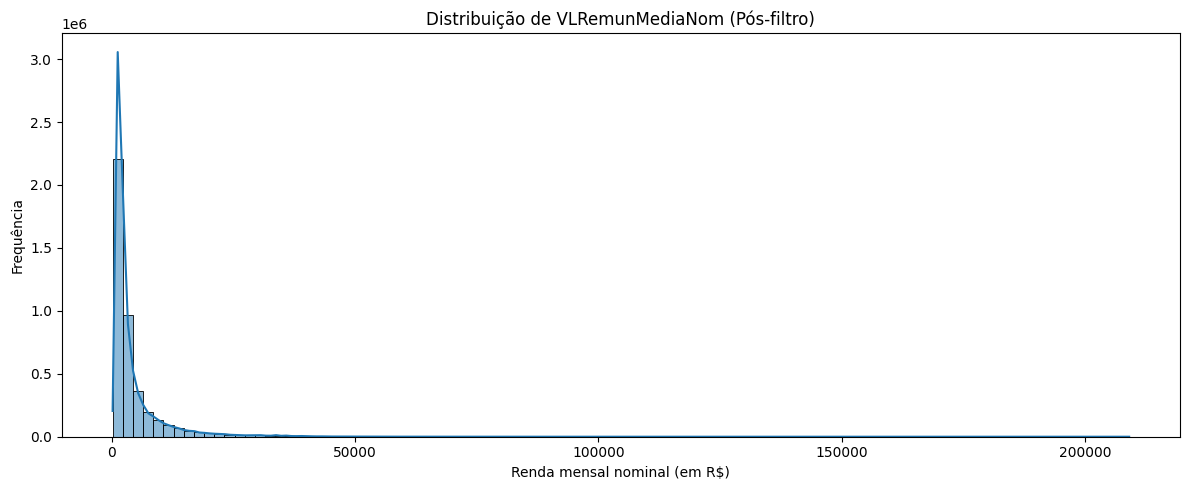

In [15]:
# Histograma
plt.figure(figsize=(12, 5))
sns.histplot(s, bins=100, kde=True)
plt.title("Distribui√ß√£o de VLRemunMediaNom (P√≥s-filtro)")
plt.xlabel("Renda mensal nominal (em R$)")
plt.ylabel("Frequ√™ncia")
plt.tight_layout()
plt.show()

In [16]:
# %% Etapa 3.6: Cria√ß√£o de um DataFrame para Normaliza√ß√£o
# Criamos uma c√≥pia para aplicar as transforma√ß√µes sem alterar o DataFrame original.
df_norm = df.copy()


In [17]:
scaler_robust = RobustScaler()
df_norm['robust_VLRemunMediaNom'] = scaler_robust.fit_transform(df_norm[['VLRemunMediaNom']])


In [18]:
scaler_std = StandardScaler()
df_norm['std_VLRemunMediaNom'] = scaler_std.fit_transform(df_norm[['VLRemunMediaNom']])


In [19]:
scaler_minmax = MinMaxScaler()
df_norm['minmax_VLRemunMediaNom'] = scaler_minmax.fit_transform(df_norm[['VLRemunMediaNom']])


In [20]:
scaler_yeoj = PowerTransformer(method='yeo-johnson')
df_norm['yeoj_VLRemunMediaNom'] = scaler_yeoj.fit_transform(df_norm[['VLRemunMediaNom']])


üìä Skew e Curtose das transforma√ß√µes:
VLRemunMediaNom                | Skew:   5.939 | Kurtosis:  69.292
log_VLRemunMediaNom            | Skew:   0.861 | Kurtosis:   0.508
robust_VLRemunMediaNom         | Skew:   5.939 | Kurtosis:  69.292
std_VLRemunMediaNom            | Skew:   5.939 | Kurtosis:  69.292
minmax_VLRemunMediaNom         | Skew:   5.939 | Kurtosis:  69.292
yeoj_VLRemunMediaNom           | Skew:   0.038 | Kurtosis:  -0.101


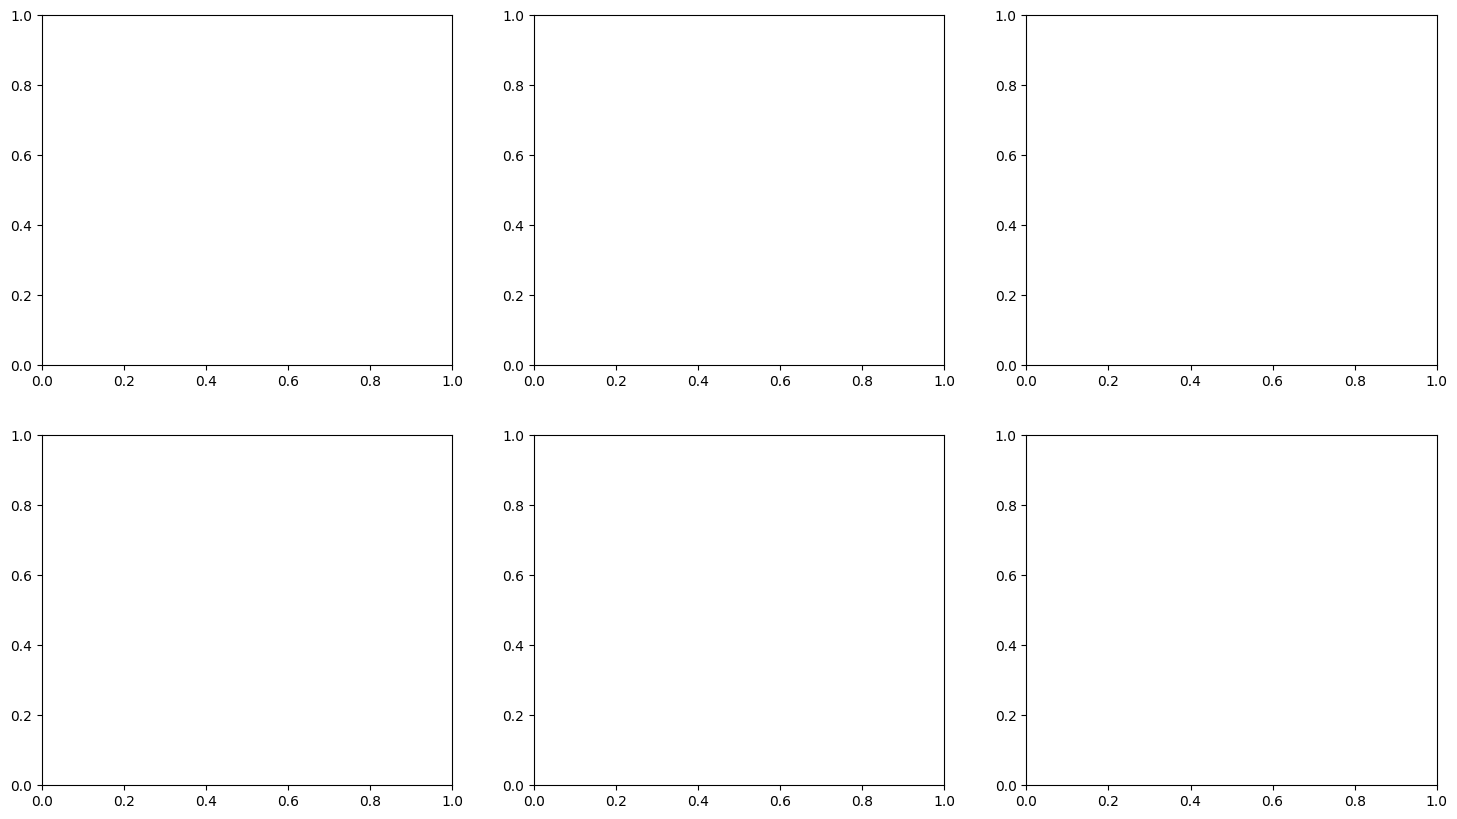

In [21]:
# Avalia√ß√£o estat√≠stica das transforma√ß√µes
print("üìä Skew e Curtose das transforma√ß√µes:")
for col in [
    'VLRemunMediaNom', 'log_VLRemunMediaNom', 'robust_VLRemunMediaNom',
    'std_VLRemunMediaNom', 'minmax_VLRemunMediaNom', 'yeoj_VLRemunMediaNom'
]:
    skew_val = skew(df_norm[col])
    kurt_val = kurtosis(df_norm[col])
    print(f"{col:<30} | Skew: {skew_val:>7.3f} | Kurtosis: {kurt_val:>7.3f}")

# %% Visualiza√ß√£o das distribui√ß√µes normalizadas
fig, axs = plt.subplots(2, 3, figsize=(18, 10))


In [22]:
sns.histplot(df_norm['log_VLRemunMediaNom'], ax=axs[0, 0], kde=True).set(title='Log1p')
sns.histplot(df_norm['robust_VLRemunMediaNom'], ax=axs[0, 1], kde=True).set(title='RobustScaler')
sns.histplot(df_norm['std_VLRemunMediaNom'], ax=axs[0, 2], kde=True).set(title='StandardScaler')
sns.histplot(df_norm['minmax_VLRemunMediaNom'], ax=axs[1, 0], kde=True).set(title='MinMaxScaler')
sns.histplot(df_norm['yeoj_VLRemunMediaNom'], ax=axs[1, 1], kde=True).set(title='PowerTransformer (Yeo-Johnson)')
sns.histplot(df_norm['VLRemunMediaNom'], ax=axs[1, 2], kde=True).set(title='Original')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [23]:
df_filtrado.to_parquet("df_filtrado_log_VLRemunMediaNom.parquet", index=False)


NameError: name 'df_filtrado' is not defined

In [ ]:

# Reimportar o DataFrame a partir do arquivo Parquet
df_filtrado = pd.read_parquet("df_filtrado_log_VLRemunMediaNom.parquet")

# Verificar as primeiras linhas
df_filtrado.head()


# Teste de hip√≥teses

In [ ]:
# Total antes do filtro
total_antes = len(df_filtrado)

# Propor√ß√£o de valores nulos no campo de carga hor√°ria
prop_nulos = df_filtrado['NRQtdHoraContr'].isna().mean()
print(f'Propor√ß√£o de valores nulos em NRQtdHoraContr: {prop_nulos:.2%}')

# Remo√ß√£o de nulos
df_horas = df_filtrado.dropna(subset=['NRQtdHoraContr', 'CDSexo'])

# Total ap√≥s o filtro
total_depois = len(df_horas)

print(f'Total de registros antes do filtro: {total_antes:,}')
print(f'Total de registros ap√≥s o filtro:  {total_depois:,}')
print(f'Total removido: {total_antes - total_depois:,}')


In [ ]:
df_horas['CDSexo'] = df_horas['CDSexo'].map({1: 'Masculino', 2: 'Feminino'})


In [ ]:
df_horas.groupby('CDSexo')['NRQtdHoraContr'].describe()


In [ ]:

plt.figure(figsize=(8,5))
sns.boxplot(x='CDSexo', y='NRQtdHoraContr', data=df_horas)
plt.title("Distribui√ß√£o da Carga Hor√°ria Contratada por Sexo")
plt.ylabel("Horas contratadas por semana")
plt.xlabel("Sexo")
plt.show()


In [ ]:


# Separa√ß√£o por sexo
homens = df_horas[df_horas['CDSexo'] == 'Masculino']['NRQtdHoraContr']
mulheres = df_horas[df_horas['CDSexo'] == 'Feminino']['NRQtdHoraContr']

# Teste de diferen√ßa de m√©dias
t_stat, p_valor = ttest_ind(homens, mulheres, equal_var=False)


print(f"Estat√≠stica t = {t_stat:.3f}")
print(f"p-valor = {p_valor:.4f}")


In [ ]:
sns.kdeplot(data=homens, label="Masculino", fill=True)
sns.kdeplot(data=mulheres, label="Feminino", fill=True)
plt.title("Distribui√ß√£o da Carga Hor√°ria Contratada por Sexo")
plt.xlabel("NRQtdHoraContr")
plt.legend()
plt.show()


In [ ]:
# Ap√≥s importar o parquet:
df_filtrado = pd.read_parquet("df_filtrado_log_VLRemunMediaNom.parquet")

# Garantir tipo string
df_filtrado['CDCBOOcupacao2002'] = df_filtrado['CDCBOOcupacao2002'].astype(str)

# Recriar a coluna com base no dicion√°rio
ocupacoes_map = {
    '0': 'MEMBROS DAS FOR√áAS ARMADAS, POLICIAIS E BOMBEIROS MILITARES',
    '1': 'MEMBROS SUPERIORES DO PODER P√öBLICO, DIRIGENTES, GERENTES',
    '2': 'PROFISSIONAIS DAS CI√äNCIAS E DAS ARTES',
    '3': 'T√âCNICOS DE N√çVEL M√âDIO',
    '4': 'TRABALHADORES DE SERVI√áOS ADMINISTRATIVOS',
    '5': 'TRABALHADORES DOS SERVI√áOS E VENDEDORES DO COM√âRCIO',
    '6': 'TRABALHADORES AGROPECU√ÅRIOS, FLORESTAIS E DA PESCA',
    '7': 'TRABALHADORES DA PRODU√á√ÉO INDUSTRIAL',
    '8': 'TRABALHADORES DA PRODU√á√ÉO INDUSTRIAL',
    '9': 'TRABALHADORES EM SERVI√áOS DE REPARA√á√ÉO E MANUTEN√á√ÉO'
}

df_filtrado['GrupoOcupacao'] = df_filtrado['CDCBOOcupacao2002'].str[0].map(ocupacoes_map)


In [ ]:
# Cria√ß√£o correta ap√≥s garantir que df_filtrado tenha a coluna
df_horas_filtrado = df_filtrado[df_filtrado['CDSexo'].isin([1, 2])]


In [ ]:
# Agrupar por grupo ocupacional e sexo
grupo_sexo_stats = (
    df_filtrado
    .dropna(subset=['NRQtdHoraContr', 'CDSexo', 'GrupoOcupacao'])
    .groupby(['GrupoOcupacao', 'CDSexo'])['NRQtdHoraContr']
    .agg(['count', 'mean', 'std'])
    .reset_index()
    .sort_values(['GrupoOcupacao', 'CDSexo'])
)

# Mostrar resultados
display(grupo_sexo_stats)


In [ ]:

# Tema visual elegante
sns.set_theme(style="whitegrid")

# N√∫mero de grupos √∫nicos
grupos = df_horas_filtrado['GrupoOcupacao'].dropna().unique()
num_grupos = len(grupos)

# Altura do gr√°fico ajustada automaticamente
altura = max(8, num_grupos * 0.7)  # aumento da altura

plt.figure(figsize=(14, altura))  # aumento da largura tamb√©m
sns.boxplot(
    data=df_horas_filtrado,
    y='GrupoOcupacao',
    x='NRQtdHoraContr',
    hue='CDSexo',
    orient='h',
    palette='pastel',           # cores suaves e claras
    fliersize=2                 # reduz tamanho dos marcadores de outliers
)

plt.title('Distribui√ß√£o da Carga Hor√°ria por Grupo Ocupacional', fontsize=14)
plt.xlabel('Carga Hor√°ria Contratada', fontsize=12)
plt.ylabel('Grupo Ocupacional', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Sexo', labels=['Masculino (1)', 'Feminino (2)'], fontsize=10, title_fontsize=11, loc='lower right')
plt.tight_layout()
plt.show()


In [ ]:

# Reimporta o DataFrame
df_horas_filtrado = pd.read_parquet("df_filtrado_log_VLRemunMediaNom.parquet")

# Ordena os grupos pela mediana da carga hor√°ria
medianas = df_horas_filtrado.groupby("GrupoOcupacao")["NRQtdHoraContr"].median().sort_values()
ordem = medianas.index.tolist()

# Plot do boxplot aprimorado
plt.figure(figsize=(10, 8))  # aumenta altura
sns.set(style="whitegrid")   # estilo limpo

sns.boxplot(
    data=df_horas_filtrado,
    y="GrupoOcupacao",
    x="NRQtdHoraContr",
    hue="CDSexo",
    order=ordem,
    showfliers=False,        # n√£o mostra outliers
    width=0.6                # largura das caixas
)

plt.title("Distribui√ß√£o da Carga Hor√°ria por Grupo Ocupacional", fontsize=14)
plt.xlabel("Carga Hor√°ria Contratada")
plt.ylabel("Grupo Ocupacional")
plt.legend(title="Sexo", labels=["Masculino (1)", "Feminino (2)"], loc="lower right")
plt.tight_layout()
plt.show()


In [ ]:

# Lista para armazenar os resultados
resultados_teste_t = []

# La√ßo por cada grupo
for grupo in df_filtrado['GrupoOcupacao'].dropna().unique():
    sub = df_filtrado.query("GrupoOcupacao == @grupo and not NRQtdHoraContr.isna() and not CDSexo.isna()")

    fem = sub.loc[sub['CDSexo'] == 'Feminino', 'NRQtdHoraContr']
    masc = sub.loc[sub['CDSexo'] == 'Masculino', 'NRQtdHoraContr']
    
    # Teste t (sem assumir vari√¢ncias iguais)
    t_stat, p_val = ttest_ind(masc, fem, equal_var=False)
    
    resultados_teste_t.append({
        'GrupoOcupacao': grupo,
        'Media_Masc': masc.mean(),
        'Media_Fem': fem.mean(),
        'Dif_Medias': masc.mean() - fem.mean(),
        't_stat': t_stat,
        'p_valor': p_val,
        'N_Masc': len(masc),
        'N_Fem': len(fem)
    })

# DataFrame com resultados
import pandas as pd
df_teste_t = pd.DataFrame(resultados_teste_t).sort_values('GrupoOcupacao')

# Mostrar
display(df_teste_t)
